In [1]:
# classification model

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D,Lambda
from tensorflow.keras.optimizers import Adam,SGD

# segmentation library

import cv2
import os
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import numpy as np


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import json

with open('labels.txt') as f:
    class_labels = json.load(f)
print(class_labels)

['adding', 'stirring', 'unknown']


In [4]:
imgsize=224
base_model = MobileNetV2(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = True
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(128))
# model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.summary()


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f86146f7550> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f860cc7bd90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f8614fa4510> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f860cc92790> True
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f8614fa4b50> True
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f860c209d50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f860c43cc10> True
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f860c43c3d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f869bfaff10> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f860c17ed10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f860c1840d0> True
<te

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,422,339
Trainable params: 2,388,227
Non-trainable params: 34,112
_________________________________________________________________


In [5]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [6]:
opt = SGD(lr=1e-4, momentum = 0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss=[focal_loss(alpha=.25, gamma=2)],
    optimizer=opt,
    metrics=['accuracy']
)

In [7]:
model = tf.keras.models.load_model('mobileNetV2Model_224', custom_objects={'focal_loss_fixed': focal_loss()})

In [8]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [9]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['hands']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


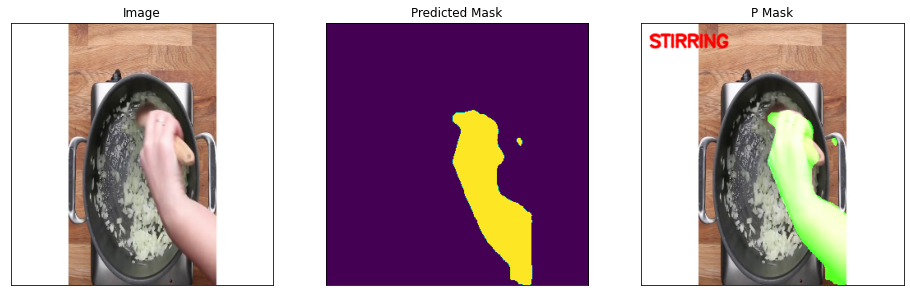

In [10]:
best_model = torch.load('segmentation/best_model.pth')
frame = cv2.imread('./test_bkp/22.jpg') # path to test image
img1 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
img1 = cv2.resize(img1, (320,320))
img = preprocessing_fn(img1)
img = img.transpose(2,0,1)
t = torch.from_numpy(img).float().to('cuda').unsqueeze(0)
pr_mask = best_model.predict(t)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())*255
ret,pr_mask = cv2.threshold(pr_mask,127,255,cv2.THRESH_BINARY)
mask_inv = np.uint8(cv2.cvtColor(cv2.bitwise_not(pr_mask), cv2.COLOR_GRAY2RGB))
a =  np.uint8(cv2.cvtColor(pr_mask, cv2.COLOR_GRAY2RGB))
greenImg = np.zeros(img1.shape, img1.dtype)
greenImg[:,:] = (0, 255, 0)
greenMask = cv2.bitwise_and(greenImg, a, mask=None)
act_img = cv2.bitwise_or(img1, mask_inv, mask=None)
dst = cv2.addWeighted(greenMask, 1, act_img, 1, 0)
classification_pred = model.predict_classes(np.float32(np.reshape(cv2.resize(frame,(imgsize,imgsize)),(1,imgsize,imgsize,3)))/255.0)
cv2.putText(dst, class_labels[int(classification_pred[0])].upper(), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(255,0,0), 2, cv2.LINE_AA)
visualize(image=img1,predicted_mask=pr_mask, p_mask=dst)